# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [2]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [3]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [4]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [5]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

In [6]:
print(train_loader)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [7]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler = None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        #print(optimizer.state_dict())
        #for param_group in optimizer.param_groups:
        #    print(epoch, param_group['lr'])        
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()            
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        if scheduler is not None:
            scheduler.step()        
        
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    
    #raise Exception("Not implemented")
    correct_samples = 0
    total_samples = 0
    for i_step, (x, y) in enumerate(loader):
            prediction = model(x)
            indices = torch.argmax(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
    accuracy = float(correct_samples) / total_samples
    return accuracy



In [8]:
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 1.847271, Train accuracy: 0.402706, Val accuracy: 0.532046
Average loss: 1.454391, Train accuracy: 0.588029, Val accuracy: 0.607126
Average loss: 1.375346, Train accuracy: 0.621131, Val accuracy: 0.629718


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [9]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),    
            nn.Linear(100, 10)
       )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.188681, Train accuracy: 0.200372, Val accuracy: 0.219098
Average loss: 2.037419, Train accuracy: 0.261543, Val accuracy: 0.304007
Average loss: 1.842125, Train accuracy: 0.357779, Val accuracy: 0.410962
Average loss: 1.719311, Train accuracy: 0.418507, Val accuracy: 0.420108
Average loss: 1.685041, Train accuracy: 0.434682, Val accuracy: 0.443314


Добавьте слой с Batch Normalization

In [10]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            torch.nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            torch.nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),    
            nn.Linear(100, 10)
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.066614, Train accuracy: 0.295089, Val accuracy: 0.387823
Average loss: 1.811386, Train accuracy: 0.428693, Val accuracy: 0.482902
Average loss: 1.677302, Train accuracy: 0.502304, Val accuracy: 0.539895
Average loss: 1.588449, Train accuracy: 0.546633, Val accuracy: 0.581121
Average loss: 1.527857, Train accuracy: 0.574890, Val accuracy: 0.601529


Добавьте уменьшение скорости обучения по ходу тренировки.

In [11]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            torch.nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            torch.nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),    
            nn.Linear(100, 10)
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma=0.5)
#scheduler1 = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,3], gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, scheduler)

Average loss: 2.050639, Train accuracy: 0.316162, Val accuracy: 0.439219
Average loss: 1.752313, Train accuracy: 0.483602, Val accuracy: 0.541601
Average loss: 1.630042, Train accuracy: 0.544705, Val accuracy: 0.579005
Average loss: 1.574497, Train accuracy: 0.574566, Val accuracy: 0.596410
Average loss: 1.534993, Train accuracy: 0.591253, Val accuracy: 0.618524


In [12]:
optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.00025,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0.1,
   'nesterov': False,
   'initial_lr': 0.001,
   'params': [139812262418184,
    139812262418832,
    139812262418400,
    139812262418328,
    139812262506928,
    139812262508440,
    139812262507504,
    139812262508008,
    139809963470496,
    139809963467328]}]}

# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [13]:
a = np.array([1,2,3])
print(a)
b=  np.array([1,2,3])
print(np.append(a, b), a, b)

[1 2 3]
[1 2 3 1 2 3] [1 2 3] [1 2 3]


In [14]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    sampler = SubsetSampler(indices)

    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                             sampler=sampler)
    predictions = np.array([])
    ground_truth = np.array([])
    for i_step, (x, y) in enumerate(loader):
            prediction = model(x)
            indices = torch.argmax(prediction, 1)            
            predictions = np.append(predictions, indices.detach().numpy())
            ground_truth = np.append(ground_truth, y.numpy())
            
    #raise Exception("Not implemented")
    
    return predictions, ground_truth

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

In [15]:
print(len(predictions), len(val_indices), len(gt))
print(gt[100], data_train[val_indices[100]][1])

14651 14651 14651
1.0 1


## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

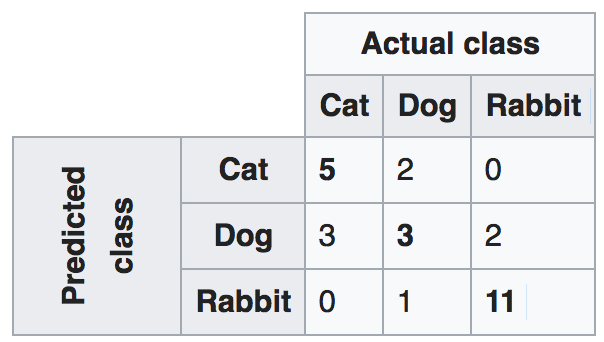

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

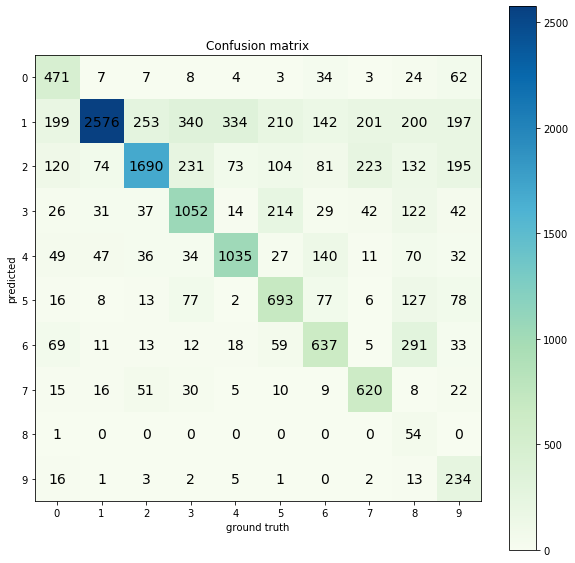

In [16]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    plt.ylim(top = -0.5, bottom = 9.5)
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """      
    confusion_matrix = np.zeros((10,10), np.int)
    
    num_features = 10
    for pred_feature in range(num_features):
        indx = predictions == pred_feature
        gt = ground_truth[indx]
        for act_feature in range(num_features):
            confusion_matrix[pred_feature, act_feature] = np.sum(gt == act_feature)
            
    
    # TODO: Implement filling the prediction matrix
    #return np.array([[40, 2, 3], [10, 50,0], [0, 2, 80]])
    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

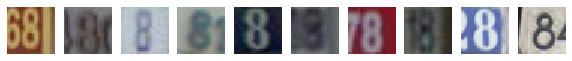

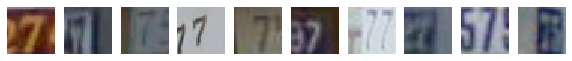

In [17]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')        
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, ground_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    #raise Exception("Not implemented")    
    mask = (predictions == predicted_class) & (ground_truth == gt_class)
    indices = np.where(mask)[0]
    
    val_data = torch.utils.data.Subset(data, val_indices)

    visualize_images(indices, val_data)

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

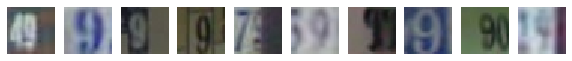

In [18]:
visualize_predicted_actual(1, 9, predictions, gt, np.array(val_indices), data_train_images)

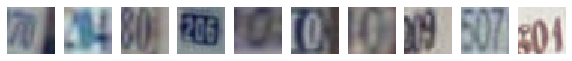

In [20]:
visualize_predicted_actual(6, 0, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [23]:
# Experiment here!
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            torch.nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            torch.nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),    
            nn.Linear(100, 10)
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma=0.9)
#scheduler1 = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,3], gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, scheduler)

#замена lr, weight_decay, gamma


Average loss: 2.052663, Train accuracy: 0.310002, Val accuracy: 0.441540
Average loss: 1.694588, Train accuracy: 0.499062, Val accuracy: 0.572111
Average loss: 1.493407, Train accuracy: 0.580521, Val accuracy: 0.624531
Average loss: 1.361975, Train accuracy: 0.624015, Val accuracy: 0.659682
Average loss: 1.263161, Train accuracy: 0.655786, Val accuracy: 0.685755


In [22]:
# Experiment here!
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            torch.nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            torch.nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),    
            nn.Linear(100, 10)
         )

optimizer = optim.Adam(nn_model.parameters(), lr=1e-3, betas = (0.9, 0.999), eps = 1e-8, weight_decay=1e-3, amsgrad = False)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma=0.9)
#scheduler1 = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,3], gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, scheduler)

#изменение оптимизатора - сильно увеличило точность (и здесь, и ниже при большем число нейронов)

Average loss: 1.372709, Train accuracy: 0.554568, Val accuracy: 0.659341
Average loss: 0.989186, Train accuracy: 0.690510, Val accuracy: 0.733670
Average loss: 0.879792, Train accuracy: 0.725864, Val accuracy: 0.741519
Average loss: 0.828698, Train accuracy: 0.740231, Val accuracy: 0.777148
Average loss: 0.770007, Train accuracy: 0.760502, Val accuracy: 0.777626


In [25]:
# Experiment here!
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            torch.nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 200),
            torch.nn.BatchNorm1d(200),
            nn.ReLU(inplace=True),    
            nn.Linear(200, 10)
         )

optimizer = optim.Adam(nn_model.parameters(), lr=1e-3, betas = (0.9, 0.999), eps = 1e-8, weight_decay=1e-3, amsgrad = False)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma=0.9)
#scheduler1 = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,3], gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, scheduler)

#изменение размера последнего слоя - сначала точность выше, в конце есть момент ухудшения на val


Average loss: 1.309712, Train accuracy: 0.578064, Val accuracy: 0.671422
Average loss: 0.950281, Train accuracy: 0.703239, Val accuracy: 0.743021
Average loss: 0.839896, Train accuracy: 0.738406, Val accuracy: 0.776602
Average loss: 0.807295, Train accuracy: 0.748302, Val accuracy: 0.776466
Average loss: 0.763503, Train accuracy: 0.763591, Val accuracy: 0.761108


In [21]:
# Experiment here!
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            torch.nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            torch.nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),    
            nn.Linear(100, 100),
            torch.nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),  
            nn.Linear(100, 10)
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma=0.9)
#scheduler1 = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,3], gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, scheduler)

#больше слоев, чем в первом варианте. точность росла с меньшего значения, но в результате выше


Average loss: 2.046672, Train accuracy: 0.306709, Val accuracy: 0.421063
Average loss: 1.669886, Train accuracy: 0.486247, Val accuracy: 0.561532
Average loss: 1.453395, Train accuracy: 0.584633, Val accuracy: 0.621664
Average loss: 1.301157, Train accuracy: 0.635703, Val accuracy: 0.664596
Average loss: 1.193197, Train accuracy: 0.664949, Val accuracy: 0.691352


In [27]:
# Experiment here!
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            torch.nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            torch.nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),    
            nn.Linear(100, 100),
            torch.nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),  
            nn.Linear(100, 10)
         )

optimizer = optim.Adam(nn_model.parameters(), lr=1e-3, betas = (0.9, 0.999), eps = 1e-8, weight_decay=1e-3, amsgrad = False)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma=0.9)
#scheduler1 = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,3], gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, scheduler)

#другой оптимизатор, снова улучшение точности (и выше, чем с меньшим число слоев)

Average loss: 1.333336, Train accuracy: 0.565010, Val accuracy: 0.681933
Average loss: 0.981304, Train accuracy: 0.689332, Val accuracy: 0.712170
Average loss: 0.868330, Train accuracy: 0.725830, Val accuracy: 0.752850
Average loss: 0.807776, Train accuracy: 0.745214, Val accuracy: 0.765204
Average loss: 0.753996, Train accuracy: 0.761646, Val accuracy: 0.779537


In [26]:
# Experiment here!
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            torch.nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            torch.nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),    
            nn.Linear(100, 100),
            torch.nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),  
            nn.Linear(100, 10)
         )

optimizer = optim.Adam(nn_model.parameters(), lr=1e-4, betas = (0.9, 0.999), eps = 1e-8, weight_decay=1e-3, amsgrad = False)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma=0.9)
#scheduler1 = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,3], gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, scheduler)

#уменьшение скорости обучения и без её изменения в процессе. В конце видно проседание на val

Average loss: 1.543788, Train accuracy: 0.521295, Val accuracy: 0.685619
Average loss: 1.047980, Train accuracy: 0.685544, Val accuracy: 0.731622
Average loss: 0.892574, Train accuracy: 0.724499, Val accuracy: 0.765204
Average loss: 0.808928, Train accuracy: 0.750350, Val accuracy: 0.769640
Average loss: 0.746836, Train accuracy: 0.767618, Val accuracy: 0.766842


In [40]:
# Experiment here!
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            torch.nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            torch.nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),    
            nn.Linear(100, 100),
            torch.nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),  
            nn.Linear(100, 10)
         )

optimizer = optim.Adam(nn_model.parameters(), lr=1e-4, betas = (0.9, 0.999), eps = 1e-8, weight_decay=1e-3, amsgrad = False)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma=0.9)
#scheduler1 = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,3], gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 10, scheduler)

#больше шагов

Average loss: 1.574038, Train accuracy: 0.513770, Val accuracy: 0.662071
Average loss: 1.068661, Train accuracy: 0.679282, Val accuracy: 0.725684
Average loss: 0.900632, Train accuracy: 0.724550, Val accuracy: 0.750119
Average loss: 0.819371, Train accuracy: 0.747057, Val accuracy: 0.759539
Average loss: 0.762747, Train accuracy: 0.763147, Val accuracy: 0.779605
Average loss: 0.724780, Train accuracy: 0.774477, Val accuracy: 0.778650
Average loss: 0.693477, Train accuracy: 0.784101, Val accuracy: 0.787660
Average loss: 0.666745, Train accuracy: 0.792479, Val accuracy: 0.803290
Average loss: 0.640725, Train accuracy: 0.799099, Val accuracy: 0.801447
Average loss: 0.622635, Train accuracy: 0.806180, Val accuracy: 0.807999


In [33]:
# Experiment here!
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            torch.nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            torch.nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),    
            nn.Linear(100, 100),
            torch.nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),  
            nn.Linear(100, 100),    
            torch.nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),    
            nn.Linear(100, 10)
         )

optimizer = optim.Adam(nn_model.parameters(), lr=1e-4, betas = (0.9, 0.999), eps = 1e-8, weight_decay=1e-3, amsgrad = False)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma=0.9)
#scheduler1 = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,3], gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, scheduler)

#увеличение числа слоев, точность немного повышается.

Average loss: 1.585931, Train accuracy: 0.489267, Val accuracy: 0.631356
Average loss: 1.084138, Train accuracy: 0.663209, Val accuracy: 0.721794
Average loss: 0.915679, Train accuracy: 0.713084, Val accuracy: 0.740564
Average loss: 0.827435, Train accuracy: 0.741238, Val accuracy: 0.764589
Average loss: 0.772787, Train accuracy: 0.757755, Val accuracy: 0.772644


In [34]:
# Experiment here!
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 50),
            torch.nn.BatchNorm1d(50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 50),
            torch.nn.BatchNorm1d(50),
            nn.ReLU(inplace=True),    
            nn.Linear(50, 50),
            torch.nn.BatchNorm1d(50),
            nn.ReLU(inplace=True),  
            nn.Linear(50, 50),    
            torch.nn.BatchNorm1d(50),
            nn.ReLU(inplace=True),    
            nn.Linear(50, 10)
         )

optimizer = optim.Adam(nn_model.parameters(), lr=1e-4, betas = (0.9, 0.999), eps = 1e-8, weight_decay=1e-3, amsgrad = False)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma=0.9)
#scheduler1 = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,3], gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, scheduler)

#уменьшение размера слоев - точность уменьшается

Average loss: 1.805853, Train accuracy: 0.403815, Val accuracy: 0.539895
Average loss: 1.318185, Train accuracy: 0.596850, Val accuracy: 0.652379
Average loss: 1.098682, Train accuracy: 0.666724, Val accuracy: 0.704116
Average loss: 0.986907, Train accuracy: 0.695168, Val accuracy: 0.721452
Average loss: 0.909503, Train accuracy: 0.717862, Val accuracy: 0.726435


In [35]:
# Experiment here!
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 50),
            torch.nn.BatchNorm1d(50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 100),
            torch.nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),    
            nn.Linear(100, 150),
            torch.nn.BatchNorm1d(150),
            nn.ReLU(inplace=True),  
            nn.Linear(150, 200),    
            torch.nn.BatchNorm1d(200),
            nn.ReLU(inplace=True),    
            nn.Linear(200, 10)
         )

optimizer = optim.Adam(nn_model.parameters(), lr=1e-4, betas = (0.9, 0.999), eps = 1e-8, weight_decay=1e-3, amsgrad = False)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma=0.9)
#scheduler1 = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,3], gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, scheduler)

# постепенное увеличение размера слоев от 50 до 200 - точность близка к размеру 100 у всех

Average loss: 1.521036, Train accuracy: 0.503754, Val accuracy: 0.668623
Average loss: 1.037166, Train accuracy: 0.673327, Val accuracy: 0.723705
Average loss: 0.916478, Train accuracy: 0.710780, Val accuracy: 0.726845
Average loss: 0.845006, Train accuracy: 0.732570, Val accuracy: 0.762201
Average loss: 0.795726, Train accuracy: 0.747961, Val accuracy: 0.771278


In [36]:
# Experiment here!
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 200),
            torch.nn.BatchNorm1d(200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 150),
            torch.nn.BatchNorm1d(150),
            nn.ReLU(inplace=True),    
            nn.Linear(150, 100),
            torch.nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),  
            nn.Linear(100, 50),    
            torch.nn.BatchNorm1d(50),
            nn.ReLU(inplace=True),    
            nn.Linear(50, 10)
         )

optimizer = optim.Adam(nn_model.parameters(), lr=1e-4, betas = (0.9, 0.999), eps = 1e-8, weight_decay=1e-3, amsgrad = False)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma=0.9)
#scheduler1 = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,3], gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, scheduler)

# обратно изменение размеров чуть выше точность в результате

Average loss: 1.642366, Train accuracy: 0.496912, Val accuracy: 0.638113
Average loss: 1.094671, Train accuracy: 0.680238, Val accuracy: 0.715310
Average loss: 0.895874, Train accuracy: 0.727332, Val accuracy: 0.754761
Average loss: 0.792738, Train accuracy: 0.753268, Val accuracy: 0.753873
Average loss: 0.732883, Train accuracy: 0.773300, Val accuracy: 0.780561


In [41]:
# Experiment here!
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 200),
            torch.nn.BatchNorm1d(200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 200),
            torch.nn.BatchNorm1d(200),
            nn.ReLU(inplace=True),    
            nn.Linear(200, 200),
            torch.nn.BatchNorm1d(200),
            nn.ReLU(inplace=True),  
            nn.Linear(200, 10)
         )

optimizer = optim.Adam(nn_model.parameters(), lr=1e-4, betas = (0.9, 0.999), eps = 1e-8, weight_decay=1e-3, amsgrad = False)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 3, gamma=0.9)
#scheduler1 = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,3], gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 6, scheduler)

#снова поменьше слоев, но большего размера - точность выше

Average loss: 1.401674, Train accuracy: 0.565659, Val accuracy: 0.707802
Average loss: 0.940302, Train accuracy: 0.709142, Val accuracy: 0.737765
Average loss: 0.794266, Train accuracy: 0.755110, Val accuracy: 0.769367
Average loss: 0.716519, Train accuracy: 0.775996, Val accuracy: 0.792233
Average loss: 0.662885, Train accuracy: 0.793844, Val accuracy: 0.805679
Average loss: 0.621829, Train accuracy: 0.805208, Val accuracy: 0.804928


In [42]:
# Experiment here!
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 200),
            torch.nn.BatchNorm1d(200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 200),
            torch.nn.BatchNorm1d(200),
            nn.ReLU(inplace=True),    
            nn.Linear(200, 200),
            torch.nn.BatchNorm1d(200),
            nn.ReLU(inplace=True),  
            nn.Linear(200, 10)
         )

optimizer = optim.Adam(nn_model.parameters(), lr=1e-4, betas = (0.9, 0.999), eps = 1e-8, weight_decay=1e-3, amsgrad = False)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma=0.9)
#scheduler1 = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,3], gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, scheduler)

#слои как выше, но небольшое уменьшение скорости в процессе - почти ничего не изменилось

Average loss: 1.388892, Train accuracy: 0.570010, Val accuracy: 0.704184
Average loss: 0.933018, Train accuracy: 0.713835, Val accuracy: 0.757354
Average loss: 0.786634, Train accuracy: 0.756185, Val accuracy: 0.772097
Average loss: 0.715002, Train accuracy: 0.777446, Val accuracy: 0.788547
Average loss: 0.654210, Train accuracy: 0.798348, Val accuracy: 0.806566


In [43]:
# Experiment here!
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 200),
            torch.nn.BatchNorm1d(200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 200),
            torch.nn.BatchNorm1d(200),
            nn.ReLU(inplace=True),    
            nn.Linear(200, 200),
            torch.nn.BatchNorm1d(200),
            nn.ReLU(inplace=True),  
            nn.Linear(200, 10)
         )

optimizer = optim.Adam(nn_model.parameters(), lr=1e-4, betas = (0.9, 0.999), eps = 1e-8, weight_decay=1e-3, amsgrad = False)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 3, gamma=0.95)
#scheduler1 = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,3], gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 10, scheduler)

# увеличение числа шагов - увеличение точности

Average loss: 1.402742, Train accuracy: 0.566580, Val accuracy: 0.703638
Average loss: 0.937967, Train accuracy: 0.713715, Val accuracy: 0.750529
Average loss: 0.800755, Train accuracy: 0.752585, Val accuracy: 0.775783
Average loss: 0.715124, Train accuracy: 0.777702, Val accuracy: 0.792096
Average loss: 0.663738, Train accuracy: 0.792922, Val accuracy: 0.805133
Average loss: 0.622694, Train accuracy: 0.804952, Val accuracy: 0.795645
Average loss: 0.590788, Train accuracy: 0.815428, Val accuracy: 0.806498
Average loss: 0.560827, Train accuracy: 0.825410, Val accuracy: 0.818920
Average loss: 0.539521, Train accuracy: 0.832594, Val accuracy: 0.824517
Average loss: 0.516147, Train accuracy: 0.839556, Val accuracy: 0.828066


In [44]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8021


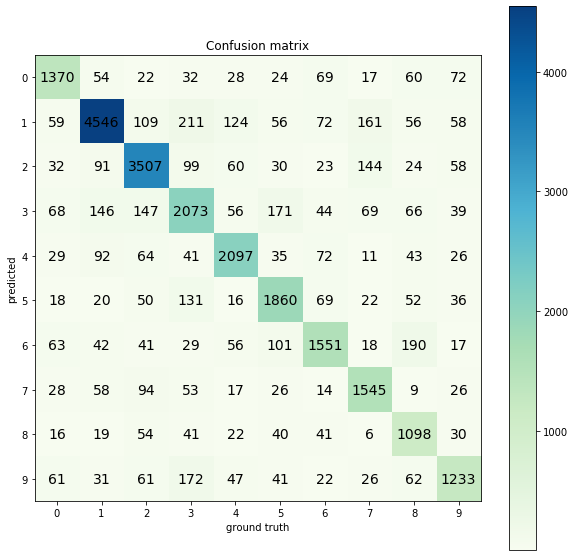

In [45]:
test_indices = list(range(data_test.data.shape[0]))

predictions, gt = evaluate_model(nn_model, data_test, test_indices)
confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)